In [513]:
%%HTML
<style>
    div#notebook-container    { width: 100%; }
</style>

In [842]:
#%matplotlib notebook
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
import tqdm
import copy
sns.set()
plt.style.use('ggplot')

In [703]:
class BanditEnv():
    def __init__(self, probs):
        self.probs = probs
        self.num_dim = probs.ndim
        self.fast_state = "[]"
        self.restart()
        
    def restart(self):
        self.state = self.fast_state
        return self.state
        
    def step(self, action):
        list_state = eval(self.state)
        list_state.append(action)
        self.state = str(list_state)
        
        if len(list_state) >= self.num_dim: # 終端状態
            self.restart()
            p = eval("self.probs" + str(list_state))
            reward = np.random.choice([0, 1], p=[1-p, p])
            is_end = True
        else:
            reward = 0
            is_end = False
            
        return self.state, reward, is_end
    
probs = np.array([[0.9, 0.2, 0.5],
             [0.2, 0.4, 0.1]])
env = BanditEnv(probs)
action = 0
print(env.step(action))
print(env.step(action))

probs = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
env = BanditEnv(probs)
action = 0
print(env.step(action))
print(env.step(action))

('[0]', 0, False)
('[]', 1, True)
('[]', 0, True)
('[]', 0, True)


In [852]:
class Agent():
    def __init__(self, key_states, policy, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.policy = policy
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.v = {}
        for i in range(len(key_states)-1):
            for key in key_states[i]:
                self.v[str(key)] = np.zeros(num_actions[i])
        self.n = copy.deepcopy(self.v)
        self.w = copy.deepcopy(self.v)
        
    def select_action(self, state):
        if policy == "random":
            action = self.random(self.v[state])
        if policy == "greedy":
            action = self.greedy(self.v[state])
        if policy == "e_greedy":
            action = self.e_greedy(self.v[state])
        return action
    
    def random(self, v):
        return np.random.randint(len(v))
    
    def greedy(self, v):
        return random.choice(np.where(v == np.max(v))[0])
    
    def e_greedy(self, v):
        if random.random() > self.epsilon:
            return self.greedy(v)
        else:
            return self.random(v)
    
    def lerning(self, state, action, reward, next_state, is_end):
        
        ### 平均
#         self.n[state][action] += 1
#         self.w[state][action] += reward
#         self.v[state][action] = self.w[state][action] / self.n[state][action]
        
        ### Q値
#         if is_end:
#             next_v = 0
#         else:
#             next_action = self.greedy(self.v[next_state]) # off policy
#             next_v = self.v[next_state][next_action]
        
#         self.n[state][action] += 1
#         self.v[state][action] = self.v[state][action] + self.alpha * (reward + (self.gamma * next_v - self.v[state][action]))

        ### 平均 and Q値
        self.n[state][action] += 1
        if is_end:
            self.w[state][action] += reward
            self.v[state][action] = self.w[state][action] / self.n[state][action]
        else:
            next_action = self.greedy(self.v[next_state]) # off policy
            next_v = self.v[next_state][next_action]
            self.v[state][action] = self.v[state][action] + self.alpha * (reward + (self.gamma * next_v - self.v[state][action]))
        
def create_key(num_actions, num_dim):
    key_states = [[] for i in range(num_dim+1)]
    key_states[0].append([])

    for i in range(num_dim):
        for j in key_states[i]:
            for k in range(num_actions[i]):
                key_states[i+1].append(j+[k])
    return key_states

最大値: 0.9


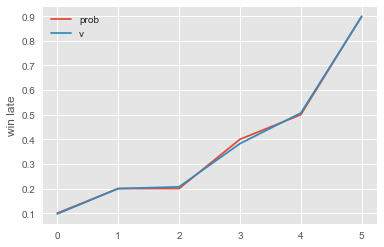

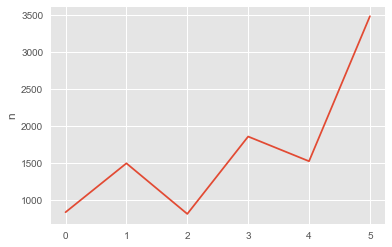

In [888]:
probs = np.array([[0.9, 0.2, 0.5],
            [0.2, 0.4, 0.1]])

#probs = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

#probs = np.random.normal(loc=0.5, scale=0.1, size=(10,30,5))
print("最大値:", np.max(probs))

policy = "e_greedy"

num_actions = probs.shape
num_dim = probs.ndim
key_states = create_key(num_actions, num_dim)

env = BanditEnv(probs)
agent = Agent(key_states, policy, alpha=0.1, epsilon=0.7)
state = env.restart()

num_episode = 10000
for i in range(num_episode):
    is_end = False
    while not(is_end):
        action = agent.select_action(state)
        next_state, reward, is_end = env.step(action)
        agent.lerning(state, action, reward, next_state, is_end)
        state = next_state
        
        
f_probs = probs.flatten()
sort_index = f_probs.argsort()
f_probs.sort()

end_v = []
end_n = []
for i in key_states[-2]: # 終端から一つ前のQ値
    end_v.append(agent.v[str(i)])
    end_n.append(agent.n[str(i)])
end_v = np.array(end_v).flatten()
end_n = np.array(end_n).flatten()

sort_v = []
sort_n = []
for i in sort_index:
    sort_v.append(end_v[i])
    sort_n.append(end_n[i])
    
plt.plot(f_probs, label="prob")
plt.plot(sort_v, label="v")
plt.ylabel("win late")
plt.legend()
plt.show()

plt.plot(sort_n)
plt.ylabel("n")
plt.show()

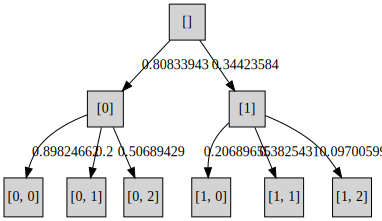

In [895]:
from graphviz import Digraph

G = Digraph(format="png")
G.attr("node", shape="square", style="filled")
G.edge("[]","[0]",label="0.80833943")
G.edge("[]","[1]",label="0.34423584")
G.edge("[0]","[0, 0]",label="0.89824662")
G.edge("[0]","[0, 1]",label="0.2")
G.edge("[0]","[0, 2]",label="0.50689429")
G.edge("[1]","[1, 0]",label="0.20689655")
G.edge("[1]","[1, 1]",label="0.3825431")
G.edge("[1]","[1, 2]",label="0.09700599")
#G.render("graphs")
G

In [889]:
agent.v

{'[0]': array([0.89824662, 0.2       , 0.50689429]),
 '[1]': array([0.20689655, 0.3825431 , 0.09700599]),
 '[]': array([0.80833943, 0.34423584])}

In [660]:
print(probs.shape)
print(probs.ndim)
num_actions = probs.shape
num_dim = probs.ndim

def create_key(num_actions, num_dim):
    key_states = [[] for i in range(num_dim+1)]
    key_states[0].append([])

    for i in range(num_dim):
        for j in key_states[i]:
            for k in range(num_actions[i]):
                key_states[i+1].append(j+[k])
    return key_states

key_states = create_key(num_actions, num_dim)

(2, 3, 5)
3


In [695]:
v = {}
for i in range(num_dim):
    for key in key_states[i]:
        v[str(key)] = np.zeros(num_actions[i])
        
v

{'[0, 0]': array([0., 0., 0., 0., 0.]),
 '[0, 1]': array([0., 0., 0., 0., 0.]),
 '[0, 2]': array([0., 0., 0., 0., 0.]),
 '[0]': array([0., 0., 0.]),
 '[1, 0]': array([0., 0., 0., 0., 0.]),
 '[1, 1]': array([0., 0., 0., 0., 0.]),
 '[1, 2]': array([0., 0., 0., 0., 0.]),
 '[1]': array([0., 0., 0.]),
 '[]': array([0., 0.])}

In [725]:
agent.v[]

{'[0, 0]': array([0.29820642, 0.30195557, 0.17211747, 0.21428182, 0.27313087]),
 '[0, 1]': array([0.18620635, 0.55726257, 0.22701471, 0.28982597, 0.18532992]),
 '[0, 2]': array([0.53811207, 0.50186726, 0.5085829 , 0.29874869, 0.76341667]),
 '[0]': array([0.34523748, 0.46780913, 0.60641515]),
 '[1, 0]': array([0.        , 0.        , 0.        , 0.38223856, 0.04782969]),
 '[1, 1]': array([0.1       , 0.        , 0.081     , 0.16710684, 0.081     ]),
 '[1, 2]': array([0.30467142, 0.47156967, 0.17018765, 0.28879007, 0.20547242]),
 '[1]': array([0.38843564, 0.26723911, 0.35452157]),
 '[]': array([0.54363315, 0.35160058])}

In [740]:
a = []
for i in key_states[-2]:
    print(i, agent.v[str(i)])
    a.append(agent.v[str(i)])
a = np.array(a).flatten()
a

[0, 0] [0.29820642 0.30195557 0.17211747 0.21428182 0.27313087]
[0, 1] [0.18620635 0.55726257 0.22701471 0.28982597 0.18532992]
[0, 2] [0.53811207 0.50186726 0.5085829  0.29874869 0.76341667]
[1, 0] [0.         0.         0.         0.38223856 0.04782969]
[1, 1] [0.1        0.         0.081      0.16710684 0.081     ]
[1, 2] [0.30467142 0.47156967 0.17018765 0.28879007 0.20547242]


array([0.29820642, 0.30195557, 0.17211747, 0.21428182, 0.27313087,
       0.18620635, 0.55726257, 0.22701471, 0.28982597, 0.18532992,
       0.53811207, 0.50186726, 0.5085829 , 0.29874869, 0.76341667,
       0.        , 0.        , 0.        , 0.38223856, 0.04782969,
       0.1       , 0.        , 0.081     , 0.16710684, 0.081     ,
       0.30467142, 0.47156967, 0.17018765, 0.28879007, 0.20547242])

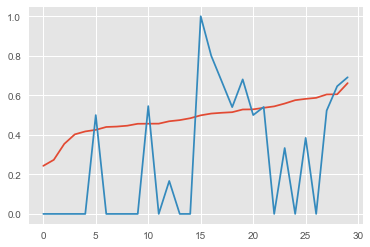

In [871]:
f_probs = probs.flatten()
sort_index = f_probs.argsort()
f_probs.sort()

end_v = []
for i in key_states[-2]: # 終端から一つ前のQ値
    end_v.append(agent.v[str(i)])
end_v = np.array(end_v).flatten()

sort_v = []
for i in sort_index:
    sort_v.append(end_v[i])
    
plt.plot(f_probs)
plt.plot(sort_v)
plt.show()

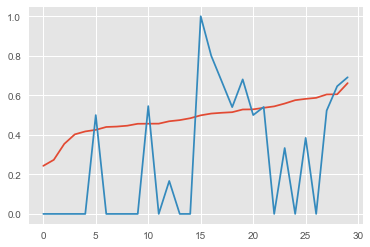

In [865]:
plt.plot(f_probs)
plt.plot(sort_v)
plt.show()

In [839]:
f_probs = probs.flatten()
print(f_probs)
sort_index = f_probs.argsort()
print(sort_index)

a = []
for i in sort_index:
    a.append(f_probs[i])
print(a)

[0.9 0.2 0.5 0.2 0.4 0.1]
[5 1 3 4 2 0]
[0.1, 0.2, 0.2, 0.4, 0.5, 0.9]


In [826]:
a = np.array([0.9, 0.2, 0.5, 0.2, 0.4, 0.1])
a.argsort()

array([5, 1, 3, 4, 2, 0])

In [836]:
a = np.array([0.2, 0.5, 0.3, 0.4])
a.argsort()

array([0, 2, 3, 1])

In [3]:
def graph_plot(ax, array, xlabel, ylabel, label=None):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if array.ndim == 1:
        if label != None:
            ax.plot(array, label=label)
            ax.legend()
        else:
            ax.plot(array)
    else:
        for k in range(len(array)):
            ax.plot(array[k], label=k)
        ax.legend()

In [4]:
class Bandit():
    def __init__(self, p):
        self.p = p
    def step(self, action):
        if self.p[action] >= random.random():
            reward = 1
        else:
            reward = 0
        return reward

In [5]:
def greedy(v):
    index = np.where(v == max(v))[0]
    return random.choice(index)

def e_greedy(v, eps):
    if random.random() > eps:
        return greedy(v)
    else:
        return random.randint(0, len(v) - 1)

class BanditAgent():
    def __init__(self, n_action, policy, exploration_eps, final_eps):
        self.v = np.zeros(n_action)
        self.n = np.zeros(n_action)
        self.sum_rew = np.zeros(n_action)
        self.policy = policy
        self.eps = 0
        self.exploration_eps = exploration_eps
        self.final_eps = final_eps

        self.aleph = 0.55
        
    def choice_action(self, e):
        if policy == "greedy":
            action = greedy(self.v)
        if policy == "e_greedy":
            action = e_greedy(self.v, self.eps)
            self.update_eps(e)
        if policy == "rs":
            action = self.rs()
        else:
            print("policy error")
        return action
    
    def update(self, action, reward):
        self.n[action] += 1
        self.sum_rew[action] += reward
        self.v[action] = self.sum_rew[action] / self.n[action]
    
    def update_eps(self, e):
        self.eps = max(self.final_eps, 1 - e / (self.exploration_eps) * (1 - self.final_eps))
        
    def rs(self):
        rs_value = self.n * (self.v - self.aleph)
        return greedy(rs_value)

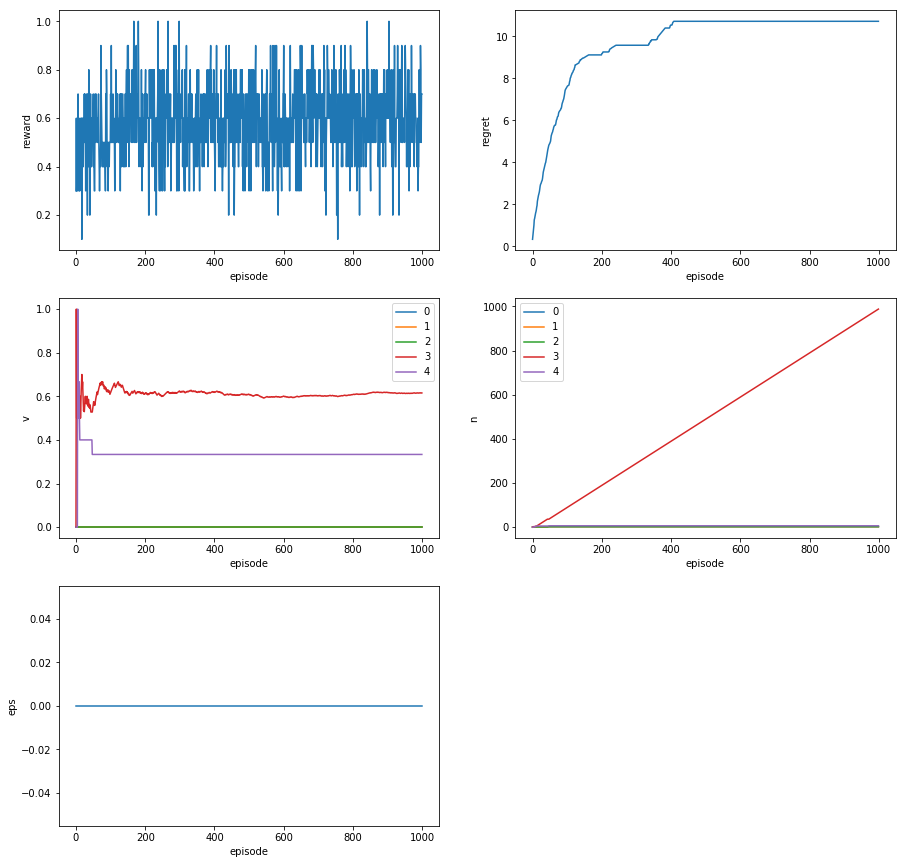

In [10]:
p = [0, 0.4, 0.1, 0.6, 0.5]
n_action = len(p)
max_p = max(p)

n_epi = 1000
n_sim = 10
policy = "rs"

exploration_eps = 0.5
final_eps = 0

if exploration_eps < 1:
    exploration_eps = n_epi * exploration_eps

# グラフ初期化
graph_reward = np.zeros(n_epi)
graph_regret = np.zeros(n_epi)
graph_v = np.zeros([n_epi, n_action])
graph_n = np.zeros([n_epi, n_action])
graph_eps = np.zeros(n_epi)

env = Bandit(np.array(p))

for s in range(n_sim):
    agent = BanditAgent(n_action, policy, exploration_eps, final_eps)
    regret = 0
    
    for e in range(n_epi):
        action = agent.choice_action(e)
        reward = env.step(action)
        agent.update(action, reward)

        # グラフ更新
        graph_reward[e] += reward / n_sim
        regret += max_p - env.p[action]
        graph_regret[e] += regret / n_sim
        graph_v[e] = agent.v # 価値のみはシミュレーションの平均をとっても意味ないので1シミュレーション分
        graph_n[e] = agent.n
        graph_eps[e] = agent.eps
        
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot2grid((3,2), (0,0))
ax2 = plt.subplot2grid((3,2), (0,1))
ax3 = plt.subplot2grid((3,2), (1,0))
ax4 = plt.subplot2grid((3,2), (1,1))
ax5 = plt.subplot2grid((3,2), (2,0))

graph_plot(ax1, graph_reward, "episode", "reward")
graph_plot(ax2, graph_regret, "episode", "regret")
graph_plot(ax3, graph_v.transpose(), "episode", "v")
graph_plot(ax4, graph_n.transpose(), "episode", "n")
graph_plot(ax5, graph_eps, "episode", "eps")

In [154]:
aleph = 0.8
q = np.array([0.1, 0.3, 0.5, 0.7])
n = np.array([0, 0, 0, 0])

for i in range(1000):
    rs_value = n * (q - aleph)
    action = greedy(rs_value)
    n[action] += 1
    
print(n)
print(n / np.sum(n))
delta = aleph - q
1 / (np.sum(1 / delta) * delta)



[ 86 121 201 602]
[0.08514851 0.11980198 0.1990099  0.5960396 ]


array([0.08522727, 0.11931818, 0.19886364, 0.59659091])

In [142]:
delta = aleph - q
delta = np.array([1, 2, 3, 4])
((1 / delta) / np.sum(delta)) / np.sum((1 / delta) / np.sum(delta))  

array([0.48, 0.24, 0.16, 0.12])

In [205]:
aleph = 0.6
q = np.array([0.1, 0.2, 0.3, 0.4])
n = np.array([0, 50, 30, 10])
fast_n = np.copy(n)

def rs_p(q, n, aleph, step):
    tmp_n = np.copy(n)
    for i in range(step):
        rs_value = tmp_n * (q - aleph)
        action = np.argmax(rs_value)
        tmp_n[action] += 1
    return (tmp_n - n) / np.sum(tmp_n - n)

print("rs_p", rs_p(q, n, aleph, 100))

for i in range(100):
    rs_value = n * (q - aleph)
    action = greedy(rs_value)
    n[action] += 1
    
print(n)
print(n / np.sum(n))

print(n - fast_n)
print((n - fast_n) / np.sum(n - fast_n))
delta = aleph - q

ratio = 1 / (np.sum(1 / delta) * delta)
print("ratio", ratio)

rs_p [0.27 0.   0.15 0.58]
[27 50 45 68]
[0.14210526 0.26315789 0.23684211 0.35789474]
[27  0 15 58]
[0.27 0.   0.15 0.58]
ratio [0.15584416 0.19480519 0.25974026 0.38961039]


In [141]:
1 / ((delta * np.sum(delta)) * np.sum(1 / ((delta * np.sum(delta)))))

array([0.08522727, 0.11931818, 0.19886364, 0.59659091])

In [107]:
1/3

array([0.45454545, 0.36363636, 0.09090909, 0.09090909])

In [227]:
class Ref(object):
    def __init__(self, value=None):
        self.value = value

def harmonic_sum(i, lo, hi, term):
    # term is passed by-name, and so is i
    temp = 0
    i.value = lo
    while i.value <= hi:  # Python "for" loop creates a distinct which
        temp += term() # would not be shared with the passed "i"
        i.value += 1   # Here the actual passed "i" is incremented.
    return temp
 
i = Ref()
 
# note the correspondence between the mathematical notation and the
# call to sum it's almost as good as sum(1/i for i in range(1,101))

print(harmonic_sum(i, 1, 100, lambda: 1.0/i.value))

5.187377517639621


In [213]:
def double(n):
    return n * 2

lambda_ver = lambda n: n * 2

print(double(2) == lambda_ver(2))

True


In [218]:
a = lambda : n * 2
a()

array([ 54, 100,  90, 136])

In [230]:
a = np.array([-1, -2, -3, -4])
((1 / a) / np.sum(a)) / np.sum((1 / a) / np.sum(a))

array([0.48, 0.24, 0.16, 0.12])

In [236]:
R = 1
q = np.array([0.1, 0.2, 0.4, 0.5])

print(R - q)
print(np.sum(R - q))
print(4 - np.sum(q))

[0.9 0.8 0.6 0.5]
2.8000000000000003
2.8


In [ ]:
a1 = []
a2 = []

alpha_1 = 0.1
a = 2
b = 1
q_value = np.aragnge(-1, 3, 0.1)
for i in q_value:
    a1.append(alpha_1 * min(max(a - i, 1e-3)**b, 1))
    a2.append(min(alpha_1 * max(a - i, 1e-3)**b, 1))
    
plt.plot(a1)
plt.show()

plt.plot(a2)
plt.show()